In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

% matplotlib inline

UsageError: Line magic function `%` not found.


## Odorant to $Ca^{2+}$ signal

https://www.sciencedirect.com/science/article/pii/S089662731301088X

$\frac { d A } { d t } = - k _ { a } A + I(t$

$\frac { d F } { d t } = - k _ { f } F + k _ { a f } A$

$\frac { d S } { d t } = - k _ { s } S - k _ { a s } A$

$R= F + S$

### $K(t) = \frac { k _ { a f } e ^ { - k _ { f } t } } { k _ { a } - k _ { f } } - \frac { k _ { a s } e ^ { - k _ { s } t } } { k _ { a } - k _ { s } } + \frac { \left( k _ { a f } \left( k _ { s } - k _ { a } \right) - k _ { a s } \left( k _ { f } - k _ { a } \right) \right) e ^ { - k _ { a } t } } { \left( k _ { a } - k _ { f } \right) \left( k _ { a } - k _ { s } \right) }$

In [84]:
ka = 1/2.99
kf = 1/0.04
ks = 1/10.88
kas = 0.0024
kaf = 1  #ralative value to kas...

Text(0, 0.5, 'Kernel')

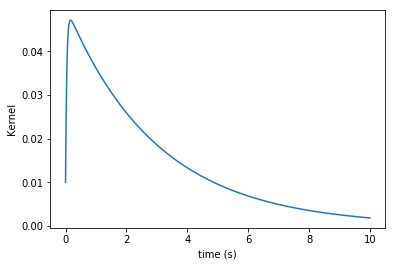

In [86]:
### analytic solution
time = 10  #sec
dt = 0.01  #~10ms
tk = np.arange(0,time,dt)
Kt = kaf/(ka-kf)*np.exp(-kf*tk) - kas/(ka-kf)*np.exp(-ks*tk) + (kas/(ka-ks) - kaf/(ka-kf))*np.exp(-ka*tk)
plt.plot(tk,Kt)
plt.xlabel('time (s)')
plt.ylabel('Kernel')

In [61]:
## noise input
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)

M = np.array([[-ka, 0, 0],[kaf, -kf, 0],[-kas, 0, -ks]])  #linear response matrix
state = np.zeros((3,len(t)))  #all three states
R = np.zeros(len(t))  #output

for tt in range(0,len(t)-1):
    state[:,tt+1] = state[:,tt] + dt*(M @ state[:,tt]) + np.array([np.random.randn(),0,0])
    R[tt] = sum(state[1:,tt])

Text(0, 0.5, 'output')

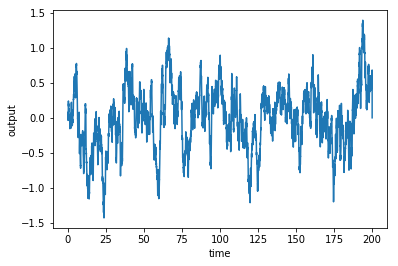

In [62]:
plt.plot(t,R)
plt.xlabel('time')
plt.ylabel('output')

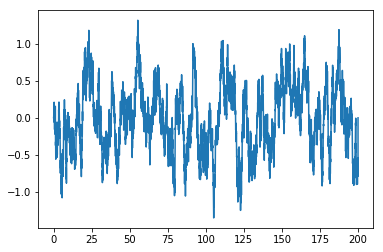

In [76]:
## periodic input
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)

M = np.array([[-ka, 0, 0],[kaf, -kf, 0],[-kas, 0, -ks]])  #linear response matrix
state = np.zeros((3,len(t)))  #all three states
R = np.zeros(len(t))  #output

f = 5  #frequency  (5Hz for 200ms flickering)
In = np.cos(t*(2*np.pi)*f)*1 + 1*np.random.randn(len(t))

for tt in range(0,len(t)-1):
    state[:,tt+1] = state[:,tt] + dt*(M @ state[:,tt]) + np.array([In[tt],0,0])
    R[tt] = sum(state[1:,tt])
    
plt.plot(t,R)

In [78]:
## infer effective kernel
win = len(Kt)  #kernel width
X = np.zeros((len(t)-win,win))

#design matrix
for xx in range(0,X.shape[0]):
    X[xx,:] = In[xx:xx+win]

In [81]:
#regression
Kest = np.linalg.inv(X.T @ X) @ X.T @ R[win:]

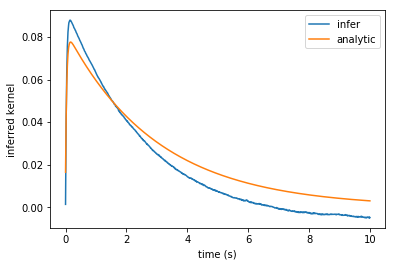

In [91]:
plt.plot(tk,np.flip(Kest)/np.linalg.norm(Kest),label='infer')
plt.xlabel('time (s)')
plt.ylabel('inferred kernel')
plt.plot(tk,Kt/np.linalg.norm(Kt),label='analytic')
plt.legend()

## LNK biophysical kinetic model 

(linear-nonlinear-kinetic)  https://www.sciencedirect.com/science/article/pii/S0896627312000797

$\frac { d \mathbf { P } ^ { \mathrm { T } } ( t ) } { d t } = \left( \begin{array} { c } { \dot { P } _ { 1 } ( t ) } \\ { \dot { P } _ { 2 } ( t ) } \\ { \dot { P } _ { 3 } ( t ) } \\ { \dot { P } _ { 4 } ( t ) } \end{array} \right)$

$=\mathbf { P } ^ { \mathrm { T } } ( t ) \left( \begin{array} { c c c c } { - u ( t ) k _ { a } } & { u ( t ) k _ { a } } & { 0 } & { 0 } \\ { 0 } & { - k _ { f i } } & { k _ { f i } } & { 0 } \\ { k _ { f r } } & { 0 } & { - \left( k _ { f r } + k _ { s i } \right) } & { k _ { s i } } \\ { 0 } & { 0 } & { u ( t ) k _ { s r } } & { - u ( t ) k _ { s r } } \end{array} \right)$

In [148]:
## kinetic rates
ka = 39
kfi = 45
kfr = 1.4
ksi = 6.
ksr = 1.

In [149]:
## LNK states driven by noise
time = 100  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)
state = np.zeros((4,len(t)))  #all three states
state[:,0] = np.random.rand(4)  #initial condition (?)

#stimulus
f = 0.1  #frequency  (5Hz for 200ms flickering)
In = (np.cos(t*(2*np.pi)*f)*1 + 1*np.random.randn(len(t)))*0.01

#dynamics
for tt in range(0,len(t)-1):
    MM = np.array([[-In[tt]*ka,In[tt]*ka,0,0],[0,-kfi,kfi,0],[kfr,0,-(kfr+ksi),0],[0,0,In[tt]*ksr,-In[tt]*ksr]])
    state[:,tt+1] = state[:,tt] + dt*(MM @ state[:,tt])

Text(0, 0.5, 'state value')

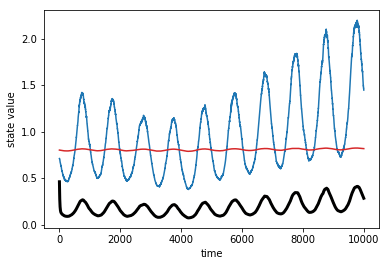

In [150]:
plt.plot(state.T);
plt.plot(state[2,:],linewidth=3,color='k')
plt.xlabel('time')
plt.ylabel('state value')